<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_Dim_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Fernando Ugalde Green 
f.ugaldegreen@estudiantec.cr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity

Importing sample data for testing. Refer to `[Feature_Densities]_CERN_uncertainties.ipynb` for implementation.

In [ ]:
dir = 'drive/MyDrive/Colab Notebooks/embeddings/layer4_pre_activation/'
pion_predictions = np.load(dir + 'pion_predictions.npy')
print('Embedding shape:', pion_predictions.shape)

Embedding shape: (948325, 128)


In [ ]:
n_samples = 1000
samples = pion_predictions[:n_samples]

Principle Component Analysis (PCA) to reduce dimensionality $\mathbb{R}^{128} \rightarrow \mathbb{R}^3$

In [ ]:
pca = PCA(3)
pion_pca = pca.fit_transform(samples)
print('PCA shape:', pion_pca.shape)
print('Explained variance:', pca.explained_variance_)
print('Explained variance %:', 100 * pca.explained_variance_ratio_)
print('Score:', pca.score(samples))

PCA shape: (10000, 3)
Explained variance: [8.722227 5.430491 4.446642]
Explained variance %: [32.406147 20.176188 16.520842]
Score: -14.909515


t-Distributed Stochastic Neighbor Embedding (tSNE) to reduce dimensionality $\mathbb{R}^{128} \rightarrow \mathbb{R}^3$ through 300 iterations

In [ ]:
tsne_params = {
    'n_components': 3,
    'perplexity': 50,
    'n_iter': 300,
}

tsne = TSNE(**tsne_params)
pion_tsne = tsne.fit_transform(samples)
print('TSNE shape:', pion_tsne.shape)
print('KL divergence:', tsne.kl_divergence_)

TSNE shape: (10000, 3)
KL divergence: 2.3470985889434814


Kernel Density Estimation (KDE) with randomized search cross-validation (1 iteration!) to compute the optimal bandwidth. Parameters are self-explanatory:

* data: Data whose density we wish to estimate.
* target_space: Target space we wish to fit x into.

Returns the tuple (estimation, bandwidth)

In [ ]:
def kde(data, target_space, h=None, debug=False):
  data = data.reshape(-1, 1)
  target_space = target_space.reshape(-1, 1)

  if not h:
    bandwidths = np.linspace(.1, 1, 50)
    grid_search = RandomizedSearchCV(KernelDensity(), {'bandwidth': bandwidths}, n_iter=1).fit(data)
    h = grid_search.best_estimator_.bandwidth

    if debug:
      print(f'Computed h = {h} with score {grid_search.best_score_}')

  kde = KernelDensity(bandwidth=h).fit(data)
  return np.exp(kde.score_samples(target_space)), h

Convenient plotting function that plots a histogram and a KDE from a given data array into a specific subplot of a figure. KDE target space is computed as the interval $[min(data), max(data)]$.

In [ ]:
def plot_ax(ax, data, i, dim):
  data = data[:, dim]

  x_plot = np.linspace(data.min(), data.max(), 100)
  pion_kde, h = kde(data, x_plot)
  h = round(h, 2)

  ax[i, dim].set_axisbelow(True)
  ax[i, dim].grid()
  ax[i, dim].hist(data, n_bins, density=True, edgecolor='black', label=f'Histogram ({n_bins} bins)')
  ax[i, dim].plot(x_plot, pion_kde, label=f'Gaussian KDE (h = {h})')

In [ ]:
def plot_ax_mini(ax, data, i, dim, h=None, debug=False):
  data = data[:, dim]

  x_plot = np.linspace(data.min(), data.max(), 100)
  pion_kde, h = kde(data, x_plot, h, debug)
  h = round(h, 2)

  ax[i, dim].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
  ax[i, dim].hist(data, n_bins, density=True)
  ax[i, dim].plot(x_plot, pion_kde)

Plotting results

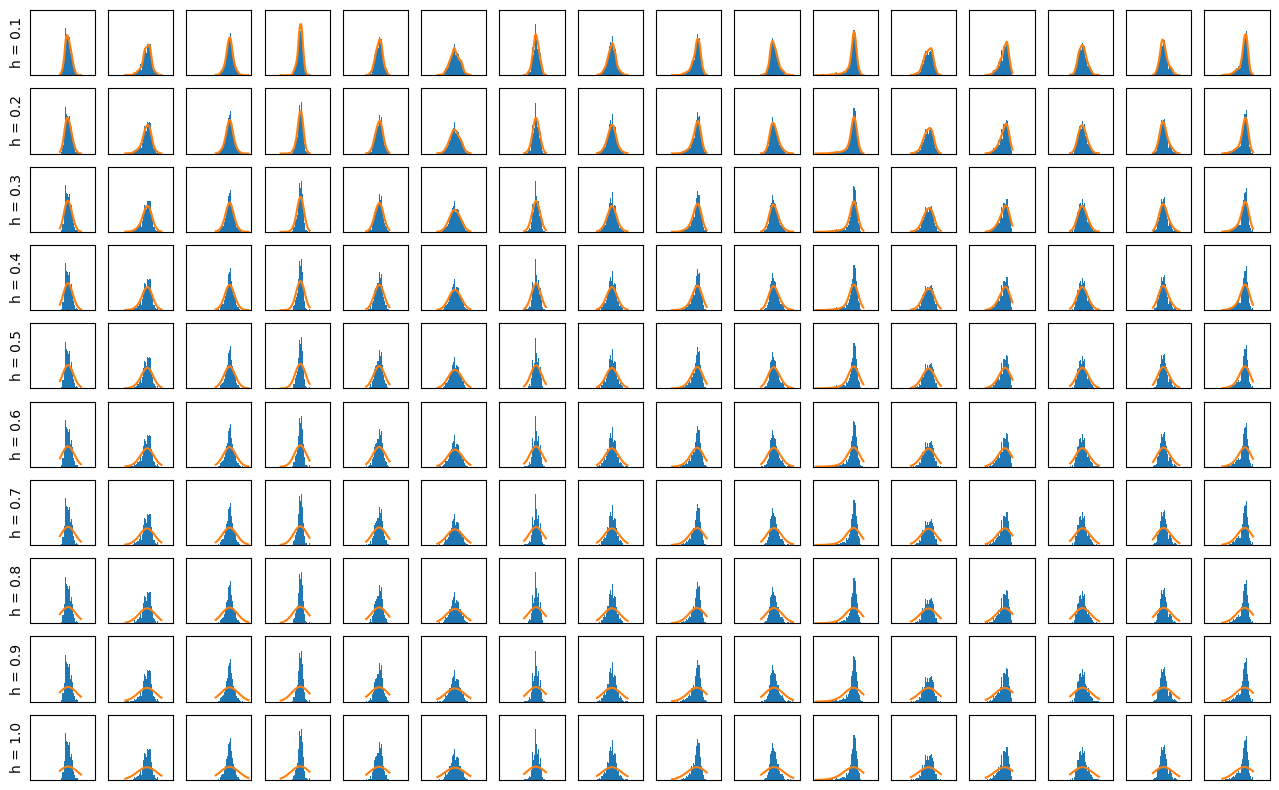

In [ ]:
n_bins = 50
n_bandwidths = 10

bandwidths = np.linspace(.1, 1, n_bandwidths)

for i in range(1):
  fig, ax = plt.subplots(n_bandwidths, 16, sharex=True, sharey=True, figsize=(16, n_bandwidths))

  for j in range(n_bandwidths):
    h = round(bandwidths[j], 2)
    ax[j, 0].set_ylabel(f'h = {h}')
    features = samples[:, i*16:(i+1)*16]
    for feature in range(16):
      plot_ax_mini(ax, features, j, feature, h)

  plt.show()

Computed h = 1.0 with score -4927.3272656512345
Computed h = 0.8530612244897959 with score -5071.799184738401
Computed h = 0.5040816326530613 with score -4062.1120270597066
Computed h = 0.8714285714285714 with score -4707.464070019164
Computed h = 0.8163265306122449 with score -4308.637123363155
Computed h = 0.41224489795918373 with score -4701.610250250244


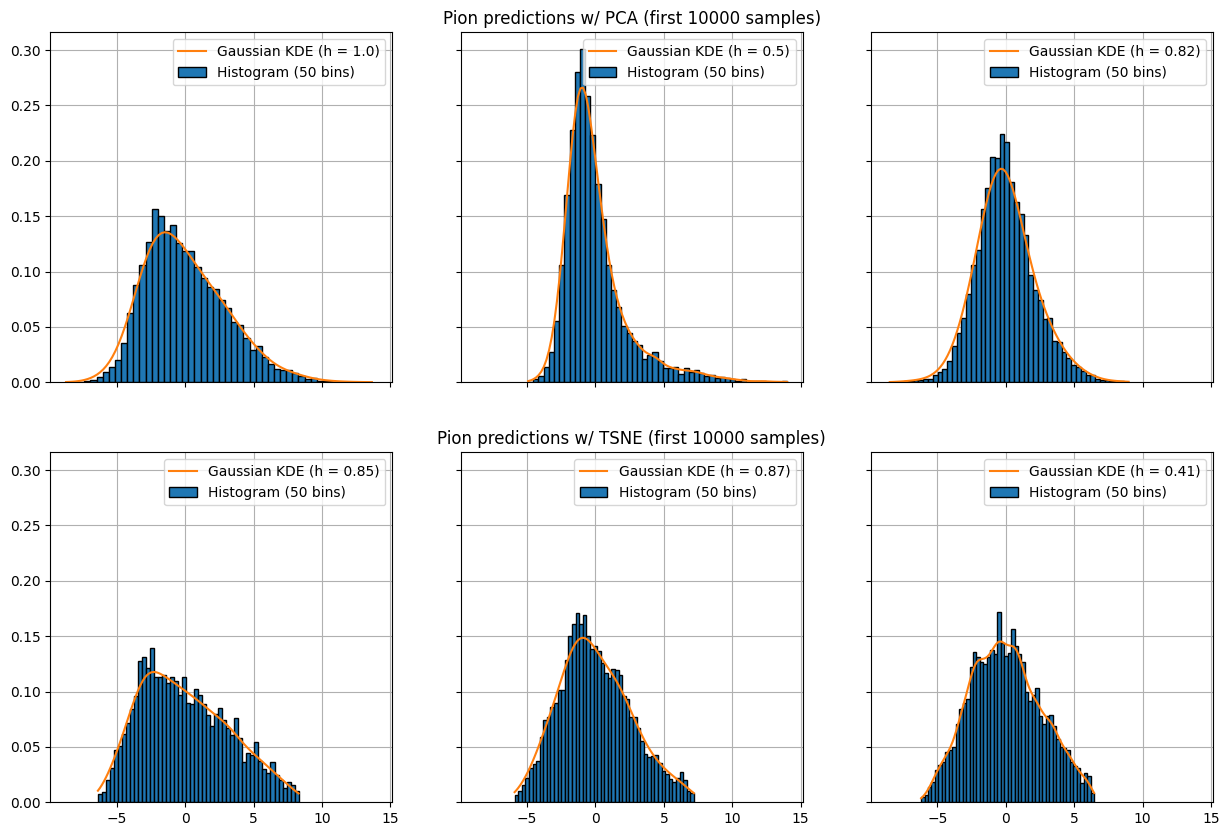

In [ ]:
n_bins = 50

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))

for dim in range(3):
  plot_ax(ax, pion_pca, 0, dim)
  plot_ax(ax, pion_tsne, 1, dim)

ax[0, 1].set_title(f'Pion predictions w/ PCA (first {n_samples} samples)')
ax[1, 1].set_title(f'Pion predictions w/ TSNE (first {n_samples} samples)')

plt.legend()
plt.show()